In [1]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/1_darcy_flow"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [2]:
from dlroms import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output as clc

In [3]:
domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.05)
clc()

In [61]:
# Load train and test data

snapshots_dir = os.path.join(os.getcwd(), "snapshots")

n_samples = 1000

K_data = np.load(os.path.join(snapshots_dir, "K_" + str(n_samples) + ".npy"))
p_data = np.load(os.path.join(snapshots_dir, "p_" + str(n_samples) + ".npy"))
u_x_data = np.load(os.path.join(snapshots_dir, "u_x_" + str(n_samples) + ".npy"))
u_y_data = np.load(os.path.join(snapshots_dir, "u_y_" + str(n_samples) + ".npy"))

N_train = int(0.8 * n_samples)
N_test = n_samples - N_train

K_train = torch.tensor(K_data[:N_train], dtype=torch.float)
p_train = torch.tensor(p_data[:N_train], dtype=torch.float)
u_x_train = torch.tensor(u_x_data[:N_train], dtype=torch.float)
u_y_train = torch.tensor(u_y_data[:N_train], dtype=torch.float)

K_test = torch.tensor(K_data[N_train:], dtype=torch.float)
p_test = torch.tensor(p_data[N_train:], dtype=torch.float)
u_x_test = torch.tensor(u_x_data[N_train:], dtype=torch.float)
u_y_test = torch.tensor(u_y_data[N_train:], dtype=torch.float)

## Deterministic network

In [80]:
# Train mesh-informed network for pressure

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.2)
layer_2 = Local(V, V, support=0.2)
layer_3 = Local(V, V, support=0.2)

p_model = DFNN(layer_1, layer_2, layer_3)
p_model.He()

p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 8:	7.32e-02	1.69e-01	nan.

>> ETA: 4m 45.72s.

Training complete. Elapsed time: 23.72 seconds.


In [ ]:
# layer = Local(V, V, support=0.1), 2 layers, 100 epochs: 1.64e-01 train, 1.99e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 2 layers, 100 epochs: 7.26e-02 train, 1.19e-01 valid (early stopping)
# layer = Local(V, V, support=0.3), 2 layers, 100 epochs: 5.21e-02 train, 1.06e-01 valid (early stopping)
# layer = Local(V, V, support=0.1), 3 layers, 100 epochs: 1.35e-01 train, 2.13e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 3 layers, 100 epochs: 4.93e-02 train, 9.25e-02 valid (early stopping) <--
# layer = Local(V, V, support=0.3), 3 layers, 100 epochs: 6.83e-02 train, 1.17e-01 valid (early stopping)

In [81]:
# Generate predictions

p_model.eval()

with torch.no_grad():
  p_pred = p_model(K_test)

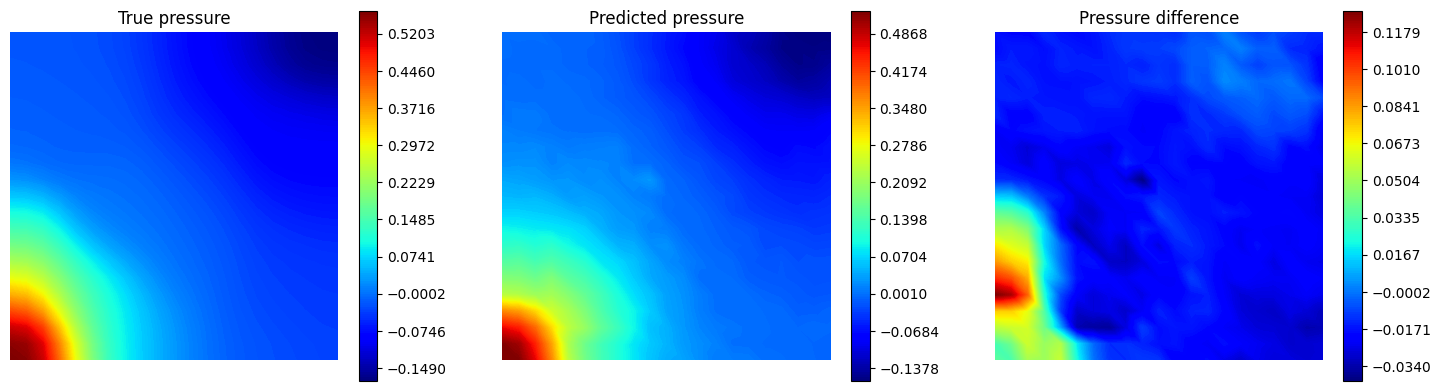

In [82]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted pressure")

plt.subplot(1, 3, 3)
fe.plot(p_test[idx] - p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure difference")

plt.show()

In [62]:
# Train encoder-decoder network for pressure

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

p_model = DFNN(psi, psi_prime)
p_model.He()

p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 72:	2.69e-02	4.44e-02	nan.

>> ETA: 1m 28.00s.

Training complete. Elapsed time: 3 minutes 38.20 seconds.


In [63]:
# Generate predictions

p_model.eval()

with torch.no_grad():
  p_pred = p_model(K_test)

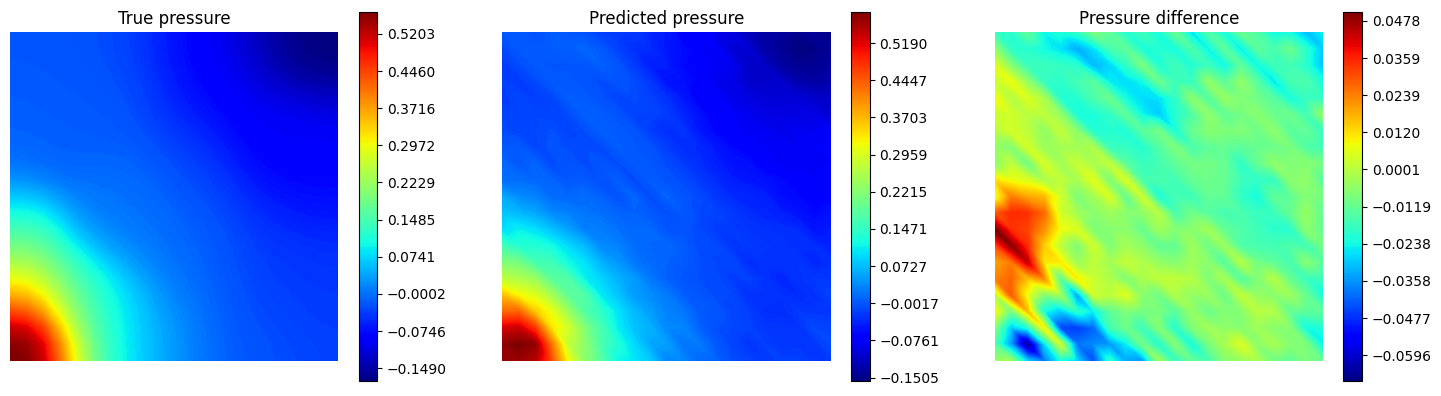

In [79]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted pressure")

plt.subplot(1, 3, 3)
fe.plot(p_test[idx] - p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure difference")

plt.show()

In [90]:
# Train network for velocity

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.2)
layer_2 = Local(V, V, support=0.2)
layer_3 = Local(V, V, support=0.2)

v_model = DFNN(layer_1, layer_2, layer_3)
v_model.He()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 11:	2.68e-01	5.69e-01	nan.

>> ETA: 2m 57.57s.

Training complete. Elapsed time: 22.05 seconds.


In [ ]:
# layer = Local(V, V, support=0.1), 2 layers, 100 epochs: 7.81e-01 train, 1.04e+00 valid (early stopping)
# layer = Local(V, V, support=0.2), 2 layers, 100 epochs: 4.56e-01 train, 7.12e-01 valid (early stopping)
# layer = Local(V, V, support=0.3), 2 layers, 100 epochs: 3.54e-01 train, 6.59e-01 valid (early stopping)
# layer = Local(V, V, support=0.1), 3 layers, 100 epochs: 7.43e-01 train, 1.37e+00 valid (early stopping)
# layer = Local(V, V, support=0.2), 3 layers, 100 epochs: 2.19e-01 train, 5.20e-01 valid (early stopping) <--
# layer = Local(V, V, support=0.3), 3 layers, 100 epochs: 2.29e-01 train, 7.65e-01 valid (early stopping)

In [91]:
# Generate predictions

v_model.eval()

with torch.no_grad():
  u_x_pred = v_model(K_test)

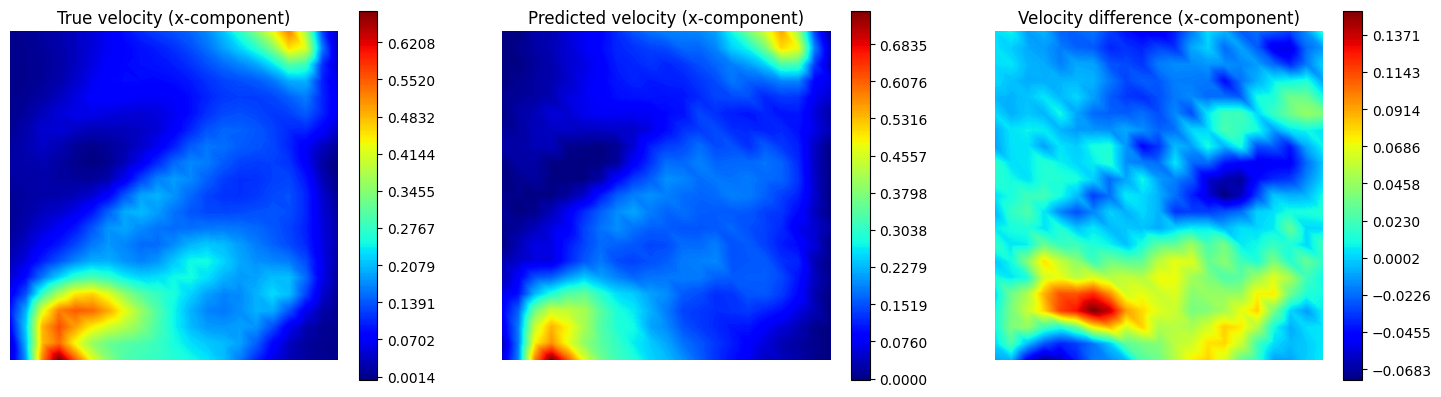

In [92]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_test[idx] - u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity difference (x-component)")

plt.show()

In [93]:
# Train encoder-decoder network for pressure

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

v_model = DFNN(psi, psi_prime)
v_model.He()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 100:	1.82e-01	2.61e-01	nan.

>> ETA: 3.14s.

Training complete. Elapsed time: 5 minutes 16.12 seconds.


In [94]:
# Generate predictions

v_model.eval()

with torch.no_grad():
  u_x_pred = v_model(K_test)

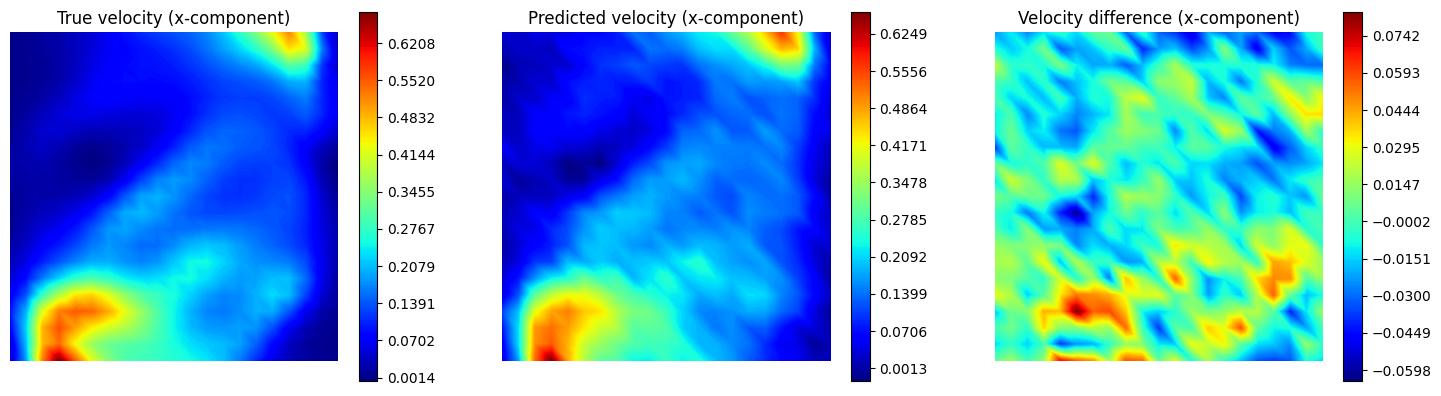

In [95]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_test[idx] - u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity difference (x-component)")

plt.show()

## Bayesian network

In [96]:
# Bayesian network for pressure

import sys
sys.path.append(os.path.join("..", "..", "dlroms"))
from bayesian import *

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.2)
layer_2 = Local(V, V, support=0.2)
layer_3 = Local(V, V, support=0.2)

p_model = DFNN(layer_1, layer_2, layer_3)

p_bayes = Bayesian(p_model)
p_bayes.He() # set prior on weights

In [97]:
p_svgd = SVGD(p_bayes, lr=1e-3)

In [98]:
p_svgd.train(K_train, p_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 2.249337, test: 2.209445: 100%|██████████| 200/200 [04:39<00:00,  1.40s/it]  


In [120]:
# p_pred_bayes = bayes(p_test)
# print(p_pred_bayes.shape) # torch.Size([20, 200, 441])

In [99]:
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.predict(p_test)

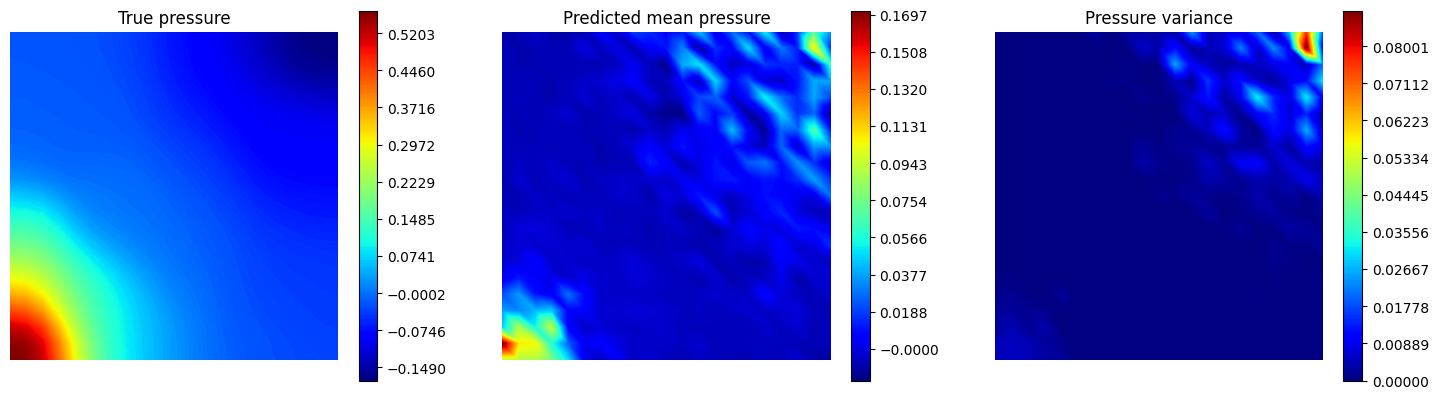

In [100]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(p_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [101]:
V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

p_model = DFNN(psi, psi_prime)

p_bayes = Bayesian(p_model)
p_bayes.He() # set prior on weights

In [102]:
p_svgd = SVGD(p_bayes, lr=1e-3)

In [103]:
p_svgd.train(K_train, p_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 0.176175, test: 0.170647: 100%|██████████| 200/200 [10:37<00:00,  3.19s/it]


In [104]:
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.predict(p_test)

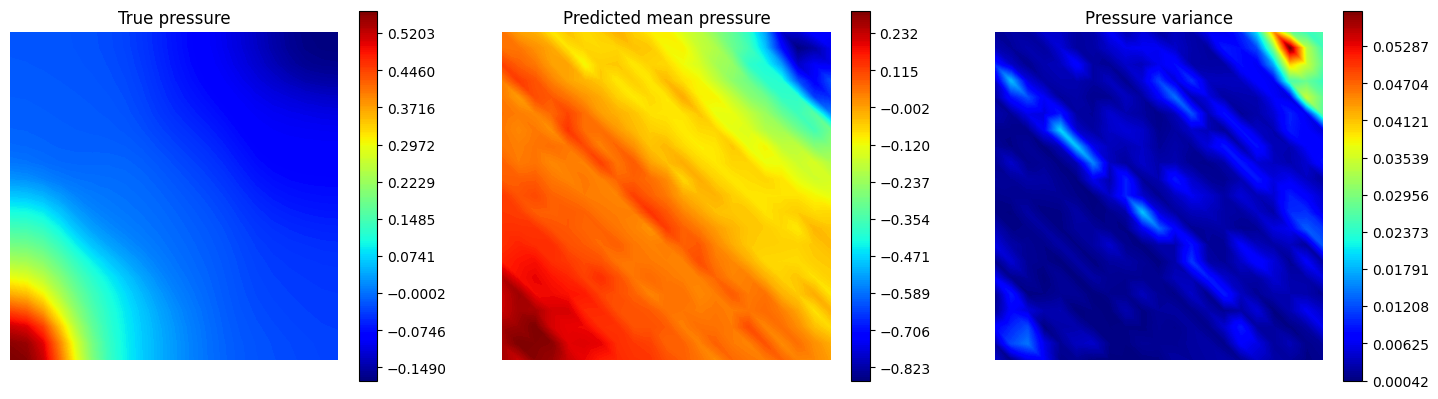

In [105]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(p_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [106]:
# Bayesian network for velocity

layer_1 = Local(V, V, support=0.2)
layer_2 = Local(V, V, support=0.2)
layer_3 = Local(V, V, support=0.2)

v_model = DFNN(layer_1, layer_2, layer_3)

v_bayes = Bayesian(v_model)
v_bayes.He() # set prior on weights

In [107]:
v_svgd = SVGD(v_bayes, lr=1e-4)

In [110]:
v_svgd.train(K_train, u_x_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 150/150, train: 14.410011, test: 14.330832: 100%|██████████| 150/150 [05:25<00:00,  2.17s/it]


In [111]:
u_x_pred_bayes_mean, u_x_pred_bayes_var = v_bayes.predict(u_x_test)

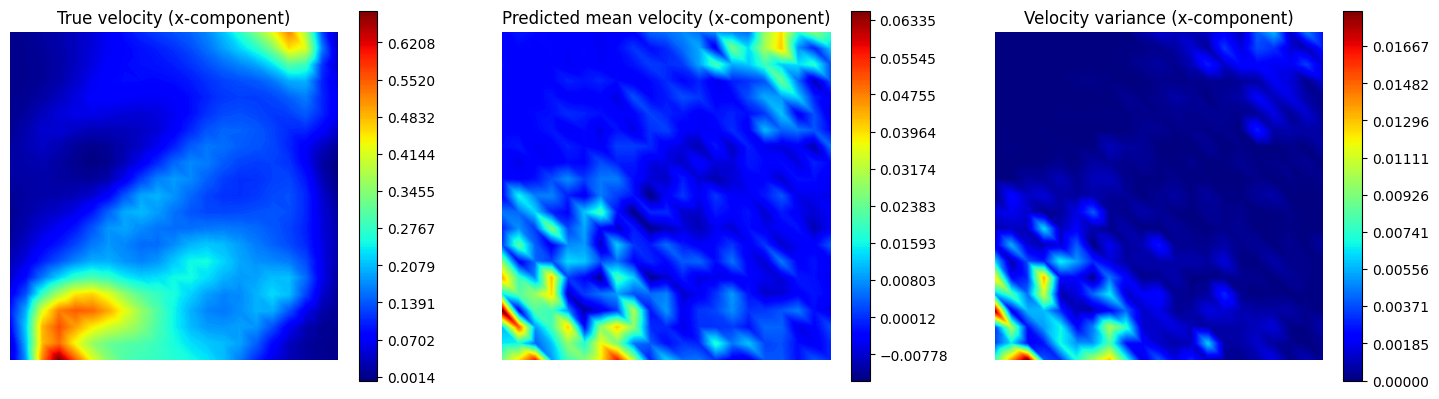

In [112]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity variance (x-component)")

plt.show()

In [113]:
V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

v_model = DFNN(psi, psi_prime)

v_bayes = Bayesian(p_model)
v_bayes.He() # set prior on weights

In [114]:
v_svgd = SVGD(v_bayes, lr=1e-3)

In [115]:
v_svgd.train(K_train, u_x_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 0.794322, test: 0.892416: 100%|██████████| 200/200 [13:39<00:00,  4.10s/it]


In [116]:
u_x_pred_bayes_mean, u_x_pred_bayes_var = v_bayes.predict(u_x_test)

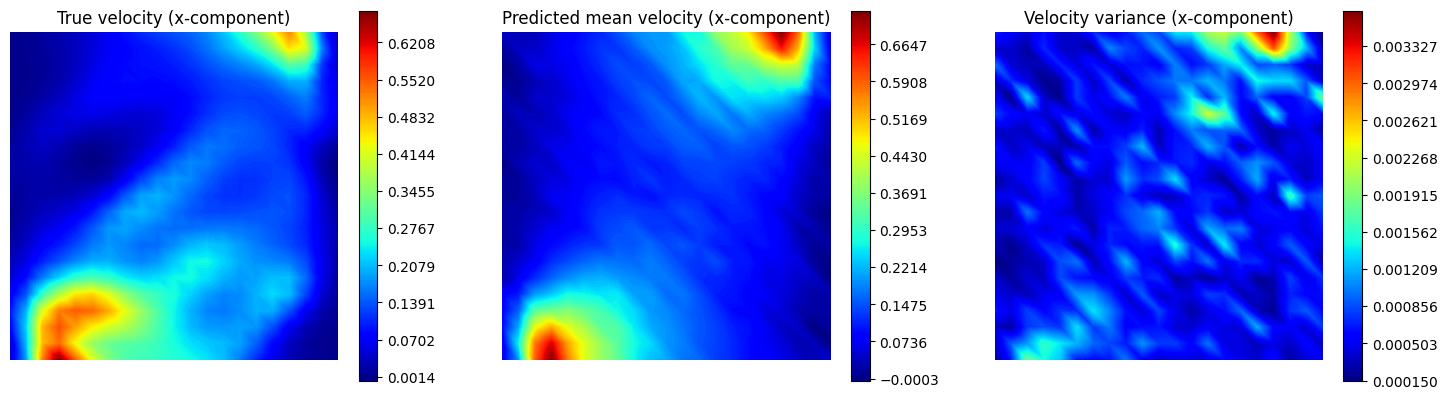

In [121]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity variance (x-component)")

plt.show()

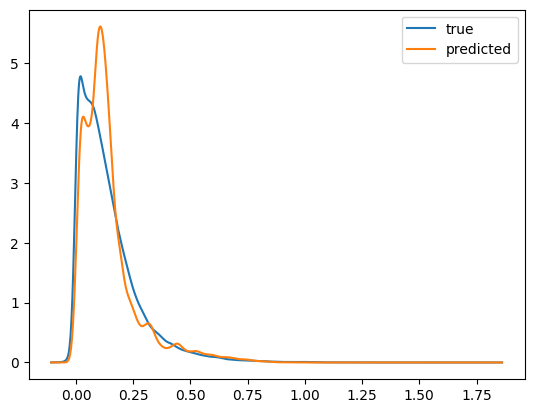

In [126]:
from scipy import stats

u_x_test_np = u_x_test.cpu().numpy().flatten()
u_x_pred_bayes_mean_np = u_x_pred_bayes_mean.cpu().numpy().flatten()

# Create a KDE estimate
kde_u_x_test = stats.gaussian_kde(u_x_test_np)
kde_u_x_pred_bayes_mean = stats.gaussian_kde(u_x_pred_bayes_mean_np)

x = np.linspace(u_x_test_np.min(), u_x_test_np.max(), 1000)
plt.plot(x, kde_u_x_test(x), label='true')
plt.plot(x, kde_u_x_pred_bayes_mean(x), label='predicted')
plt.legend()
plt.show()

Reliability Diagram:

1. Compute the p% predictive interval for each test data point based on the Gaussian quantiles using the predictive mean and variance;
2. Compute the frequency of the test targets that fall within this predictive interval.

For a well-calibrated regression model, the observed frequency should be close to p%. The reliability diagram is the plot of the observed frequency with respect to p.

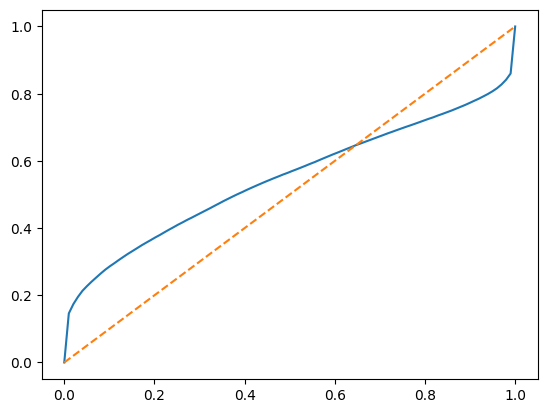

In [127]:
from scipy.stats import norm

u_x_test_np = u_x_test.cpu().numpy().flatten()
u_x_pred_bayes_mean_np = u_x_pred_bayes_mean.cpu().numpy().flatten()
u_x_pred_bayes_var_np = u_x_pred_bayes_var.cpu().numpy().flatten()

quantiles = np.linspace(0, 1, 100)

calibration_curve = np.zeros_like(quantiles)

for i in range(len(u_x_test_np)):
	normal_quantiles = norm.ppf(quantiles, loc=u_x_pred_bayes_mean_np[i], scale=np.sqrt(u_x_pred_bayes_var_np[i]))
	mask = (normal_quantiles > u_x_test_np[i])
	calibration_curve += mask
	
calibration_curve /= len(u_x_test_np)

plt.plot(quantiles, calibration_curve)
plt.plot(quantiles, quantiles, '--')
plt.show()

- Tradeoff memory vs execution time (is mesh-informed prior "sparse enough" to enable vectorized implementation? which are the limits?)
- torch.jit to make basic operation (e.g. matmul) faster
- Verbose, ETA, etc. (like in ROM)
- Choice of prior?